### This Kaggle competition is about classifying texts. It is an excellent introduction to Natural Language Processing (NLP). 



The project has 125 total points. The instructions summarize the criteria you will use to guide your submission and review others’ submissions. Note: to receive total points for this section, the learner doesn't need to have a top-performing score on the challenge. This is a mini-project to complete as a weekly assignment, so we don't expect you to iterate over your project until you have a model capable of winning the challenge. The learner needs to show a score that reasonably reflects that they completed the rubric parts of this project, E.g., a model score above 0.00000.  

github：https://github.com/zpeople/NLP-Disaster-Tweets

[12/05/2024 Thu 10:56:39] BY Renmin Zhao

#### Load data 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# pd display setting
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.width', 4000)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.max_colwidth', None)

#load data
train_path ="./Datasets/train.csv"
test_path="./Datasets/test.csv"
train_data = pd.read_csv(train_path)
test_data =pd.read_csv(test_path)

print('Development  data size:',train_data.shape)
print('Predict data size:',test_data.shape)

Development  data size: (7613, 5)
Predict data size: (3263, 4)


### Brief description of the problem and data (5 pts)

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data. 

In [42]:
print(train_data.info())
print(train_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
         id keyword location                                                                                                                                       text  target
0         1     NaN      NaN                                                                      Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all       1
1         4     NaN      NaN                                                                                                     Forest fire near La Ronge Sask. Canada       1
2         5     NaN      NaN      All resid

In [3]:
print(test_data.info())
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None
   id keyword location                                                                                              text
0   0     NaN      NaN                                                                Just happened a terrible car crash
1   2     NaN      NaN                                  Heard about #earthquake is different cities, stay safe everyone.
2   3     NaN      NaN  there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all
3   9     NaN      NaN                                                          Apocalypse lighting. #Spokane #wildfires
4  1

In [4]:
print('location null counts:',train_data['location'].isnull().sum())
print('keyword null counts:',train_data['keyword'].isnull().sum())


location null counts: 2533
keyword null counts: 61


The features are keyword, location, text, and only loction has a large amount of missing data

In [5]:
#Null Accuracy
train_data['target'].value_counts(normalize=True)

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64

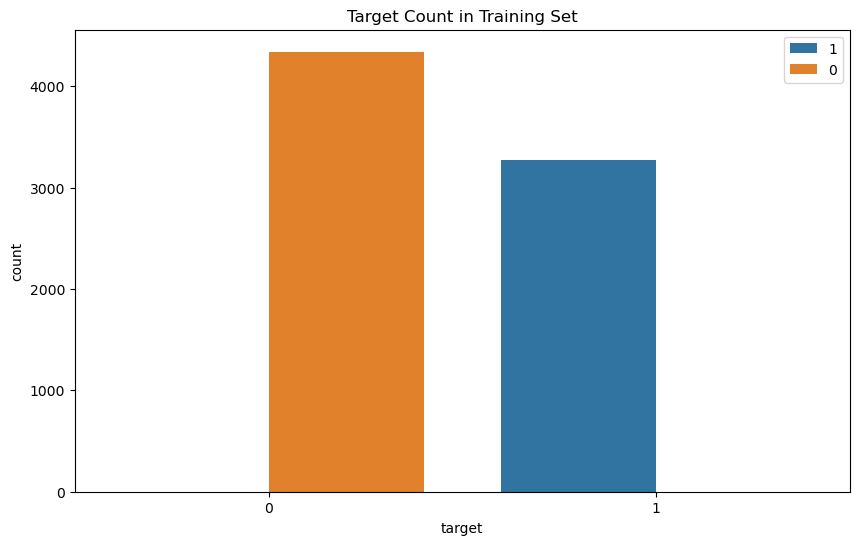

In [6]:
fig = plt.figure(figsize=(10,6))
plt.tight_layout()

train_data.groupby('target').count()['id']
sns.countplot(x=train_data['target'], hue=train_data['target'].astype(str))
plt.legend(loc=0)
plt.title('Target Count in Training Set')

plt.show()


### Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

In [7]:
# keyword location text  ---target


loc_tar1=train_data[train_data['target'] == 1]['location']
print(len(loc_tar1.unique())/len(loc_tar1))

loc_tar0=train_data[train_data['target'] == 0]['location']
print(len(loc_tar0.unique())/len(loc_tar0))

loc_count_tar1 = loc_tar1.value_counts()
loc_count_tar0 = loc_tar0.value_counts()

count= 5

print(loc_count_tar1[loc_count_tar1>count].info(),'\n')
print(loc_count_tar0[loc_count_tar0>count].info(),'\n')

common_locs = set(loc_count_tar1[loc_count_tar1>count].index).intersection(set(loc_count_tar0[loc_count_tar0>count].index))

print("Number of common loc:", len(common_locs))

0.4628553959033935
0.4935513588208199
<class 'pandas.core.series.Series'>
Index: 30 entries, USA to Ireland
Series name: count
Non-Null Count  Dtype
--------------  -----
30 non-null     int64
dtypes: int64(1)
memory usage: 480.0+ bytes
None 

<class 'pandas.core.series.Series'>
Index: 35 entries, New York to Dallas, TX
Series name: count
Non-Null Count  Dtype
--------------  -----
35 non-null     int64
dtypes: int64(1)
memory usage: 560.0+ bytes
None 

Number of common loc: 18


The proportion of unique data is as high as 0.5, indicating that the data set has considerable diversity, and each instance has its own unique characteristics. By comparing positive and negative data, there are 18 sets of data duplicates in positive and negative data, accounting for about 2/3, and disaster comments are not closely related to location

In [8]:
key_tar1=train_data[train_data['target'] == 1]['keyword']
print(len(key_tar1.unique())/len(key_tar1))

key_tar0=train_data[train_data['target'] == 0]['keyword']
print(len(key_tar0.unique())/len(key_tar0))

key_count_tar1 = key_tar1.value_counts()
key_count_tar0 = key_tar0.value_counts()

print(key_count_tar1.head(100) ,'\n')
print(key_count_tar0.head(100),'\n')
# Convert index to set and find intersection


common_keys = set(key_count_tar1[key_count_tar1>20].index).intersection(set(key_count_tar0[key_count_tar0>20].index))
# Output the number of common keys
print("Number of common keys:", len(common_keys))


0.06756343625802506
0.05043758636573008
keyword
derailment     39
wreckage       39
outbreak       39
debris         37
oil%20spill    37
               ..
disaster       15
casualty       15
hostage        15
bomb           15
collapse       15
Name: count, Length: 100, dtype: int64 

keyword
body%20bags          40
harm                 37
armageddon           37
wrecked              36
ruin                 36
                     ..
dead                 23
emergency            23
nuclear%20reactor    22
collapsed            22
damage               22
Name: count, Length: 100, dtype: int64 

Number of common keys: 0


In [9]:
key_train=train_data['keyword'].value_counts()
print(key_train.shape)
key_test =test_data['keyword'].value_counts()
print(key_test.shape)
common_keys = set(key_train[key_train>0].index).intersection(set(key_test[key_test>0].index))

print("The number of keywords common to the training and test data:", len(common_keys))

(221,)
(221,)
The number of keywords common to the training and test data: 221


* keyword has less diversity than location, which may make the correlation between the keyword and the target category easier to detect.
* The number of positive and negative data types of keyword is more balanced, which is usually conducive to detecting the relationship between features and targets
* Keyword for positive and negative data do not have obvious similarities

#### Clean Text Data

In [ ]:
!pip install pyspellchecker

In [ ]:
from spellchecker import SpellChecker


spell = SpellChecker()
def correct_spellings(text):
    if pd.isna(text) or not isinstance(text, str):
        return text
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_word = spell.correction(word)
            corrected_text.append(corrected_word if isinstance(corrected_word, str) else word)
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [3]:
import re
import string
import nltk
import pandas as pd
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# retrieve english stop words
stop_words = set(stopwords.words('english'))

# Converts text to lower case
def convert_to_lowercase(text):
    if pd.isna(text):
        return text
    if isinstance(text, str):
        return text.lower()
    return text

# Remove all punctuation from the text
def remove_punctuation(text):
    if pd.isna(text):
        return text
    text = re.sub(f'[{string.punctuation}]', '', text)
    return text

# Removes all numbers from the text
def remove_numbers(text):
    if pd.isna(text):
        return text
    text = re.sub(r'\d+', '', text)
    return text

# Text segmentation, then remove the length of 2 or less and the single word and stop word
def remove_short_words_and_stop_words(text):
    if pd.isna(text):
        return text
    words = word_tokenize(text)
    words = [word for word in words if len(word) > 2 and word not in stop_words]
    cleaned_text = ' '.join(words)
    return cleaned_text

# Replace two or more consecutive Spaces with a single space
def remove_multiple_spaces(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r' {2,}', ' ', text)
    return cleaned_text

# Remove urls
def remove_urls(text):
    if pd.isna(text):
        return text
    url_pattern = r'(www.|http[s]?://)(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)

# Remove hmtmls
def remove_html(text):
    if pd.isna(text):
        return text
    html_entities = r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});'
    return re.sub(html_entities, '', text)

# Remove @ and #
def remove_tags(text):
    if pd.isna(text):
        return text
    tag_pattern = r'@([a-z0-9]+)|#'
    return re.sub(tag_pattern, '', text)

def remove_emoji(text):
    if pd.isna(text):
        return text
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_text(text):
    if pd.isna(text):
        return text
    cleaned_text = re.sub(r'[^a-zA-Z\d\s]+', '',text)
    word_list = []
    for each_word in cleaned_text.split(' '):
        word_list.append((each_word).lower())
    word_list = [
        WordNetLemmatizer().lemmatize(each_word.strip()) for each_word in word_list
        if each_word not in stop_words and each_word.strip() != ''
    ]
    return " ".join(word_list)



def clear_text(df, col):
    df[col] = df[col].apply(convert_to_lowercase)
    df[col] = df[col].apply(remove_urls)
    df[col] = df[col].apply(remove_html)
    df[col] = df[col].apply(remove_tags)
    df[col] = df[col].apply(remove_numbers)
    df[col] = df[col].apply(remove_short_words_and_stop_words)
    df[col] = df[col].apply(preprocess_text)
    df[col] = df[col].apply(remove_multiple_spaces) 
    # df[col] = df[col].apply(remove_emoji) 
    # df[col] = df[col].apply(correct_spellings)
    return df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\SEELE\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
train_data['keyword']

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
7608    NaN
7609    NaN
7610    NaN
7611    NaN
7612    NaN
Name: keyword, Length: 7613, dtype: object

The keyword of the training set and the test set are exactly the same, indicating that the keyword of the training set can be used on the test set.

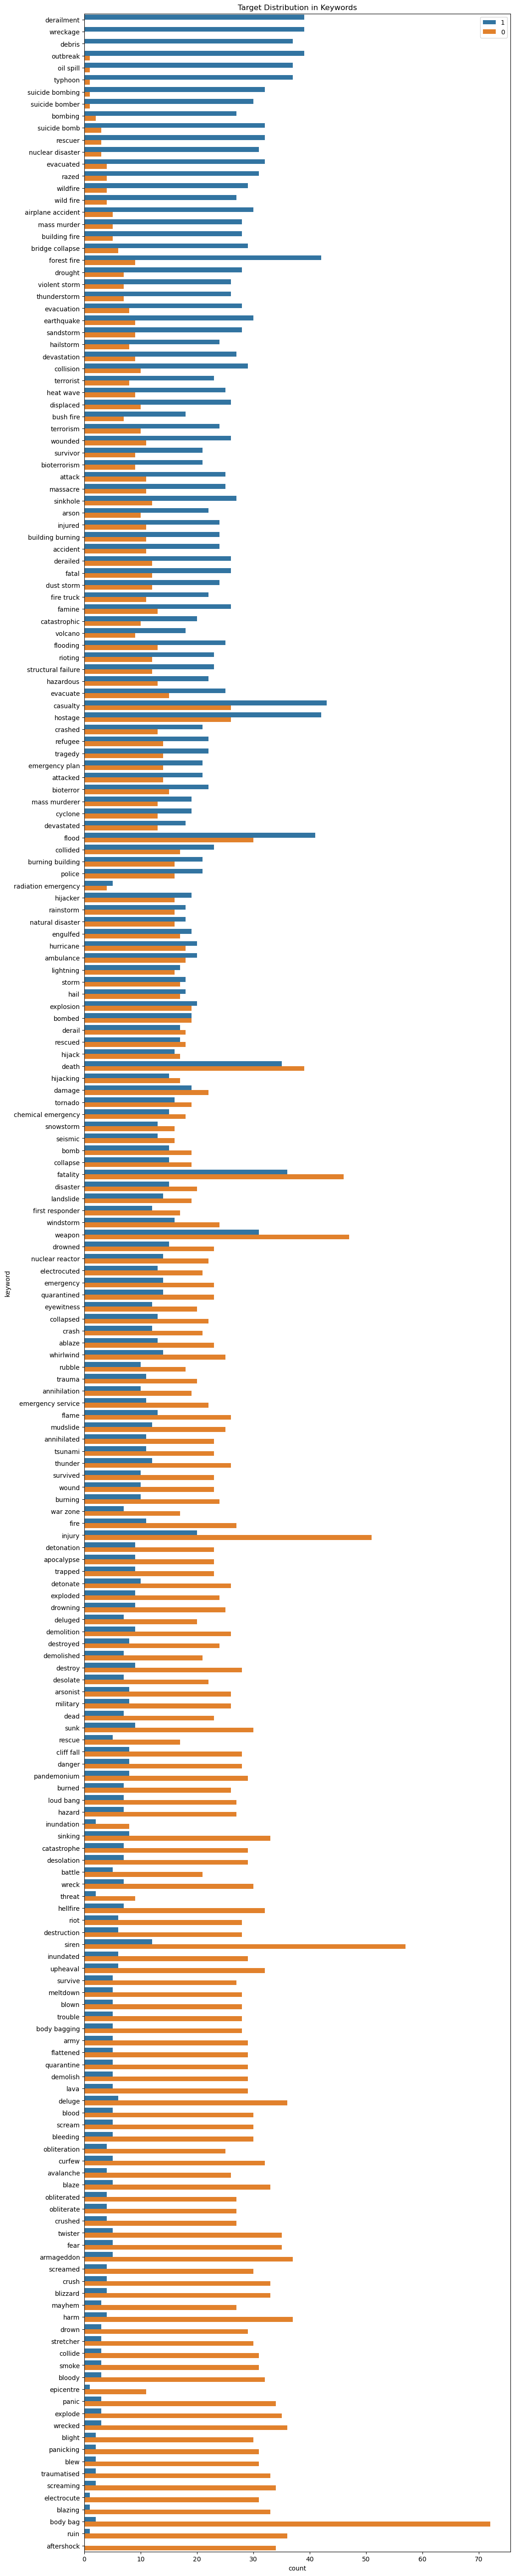

In [4]:
# Group by keyword to extract the average value of the target
train_data =clear_text(train_data,'keyword')
train_data['target_mean'] = train_data.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(12,72))
sorted_data = train_data.sort_values(by='target_mean', ascending=False)
# Graphs are drawn according to keyword and sorted in descending order by target_mean
sns.countplot(y=sorted_data['keyword'], hue=sorted_data['target'].astype(str))

plt.legend(loc=0)
plt.title('Target Distribution in Keywords')

plt.show()

# Drop column
train_data.drop(columns=['target_mean'], inplace=True)
test_data =clear_text(test_data,'keyword')

Some words appear only in disaster tweets, while others appear only in non-disaster tweets. Description keyword is an available field

#### Merge data and clear data in a unified manner ==> Fulldata

In [5]:

# concat train and test data
full_data = pd.concat([train_data,test_data],ignore_index=True)
full_data['keyword'] = full_data['keyword'].fillna('UNK')
full_data = full_data.drop(['id','location'],axis=1)


print(full_data['text'].head(-10))

#clear text
full_data = clear_text(full_data,'text')


0                                                                           Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1                                                                                                          Forest fire near La Ronge Sask. Canada
2           All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3                                                                               13,000 people receive #wildfires evacuation orders in California 
4                                                        Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
                                                                           ...                                                                   
10861                                                             Smackdown tyme this should put me in a good mood again sin

In [6]:

print('-------------cleardata:\n',full_data['text'].head(-10)) #Check if clear succeeds
print(full_data.shape)  # full_data.shape[1]==3
print(full_data[full_data['target'].notnull()].shape)

-------------cleardata:
 0                                                                     deed reason earthquake may allah forgive
1                                                                           forest fire near ronge sask canada
2                        resident asked shelter place notified officer evacuation shelter place order expected
3                                                          people receive wildfire evacuation order california
4                                                       got sent photo ruby alaska smoke wildfire pours school
                                                         ...                                                  
10861                                                       smackdown tyme put good mood since got wrecked smh
10862                                     jsyk nt stopped thinking abt remus slumped bathroom door day wrecked
10863                                begovic garbage got wrecked red bull reserve team 

View the number of keyword features after cleaning

In [15]:
from sklearn.feature_extraction.text import CountVectorizer


vec = CountVectorizer(lowercase=True,stop_words='english')
kw_X_train =vec.fit_transform( full_data[full_data['target'].notnull()]['keyword'].values).todense()
kw_X_test = vec.transform( full_data[full_data['target'].isnull()]['keyword'].values).todense()
kw_X_train.shape  #==(7613, 212)


(7613, 216)

View the number of features in the cleaned text

(3271, 7019)
(7019,)


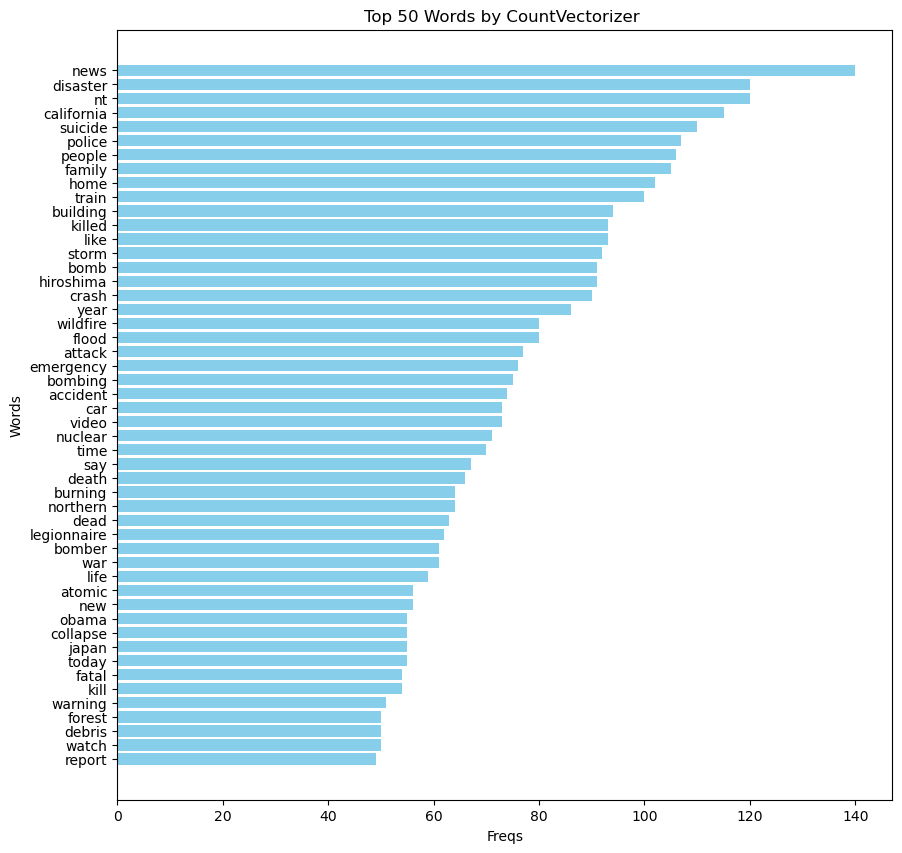

In [16]:
from sklearn.feature_extraction.text import CountVectorizer



vec = CountVectorizer(lowercase=True,stop_words='english')
# texts_with_target_1 = full_data[full_data['target'] == 1]['text']
texts_with_target_1=  full_data[full_data['target'] == 1]['text']
text_X_cv = vec.fit_transform(texts_with_target_1)
print(text_X_cv.shape)
vocab = vec.get_feature_names_out()

freqs = text_X_cv.sum(axis=0).tolist()[0]
feature_names = vec.get_feature_names_out()
print(feature_names.shape)
freqs_data = pd.DataFrame({
    'word': feature_names,
    'freqs': freqs
})
top_n = 50
top_n_freqs = freqs_data.sort_values(by='freqs', ascending=False).head(top_n)


plt.figure(figsize=(10, 10))
plt.barh(top_n_freqs['word'], top_n_freqs['freqs'], color='skyblue')
plt.xlabel('Freqs')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by CountVectorizer ')
plt.gca().invert_yaxis()
plt.show()


It can be found that using CountVectorizer with too many features will not only lead to excessive memory consumption, but also significantly reduce the speed of model training and prediction

feature sizs: 7166
(7166,)
(7166,)


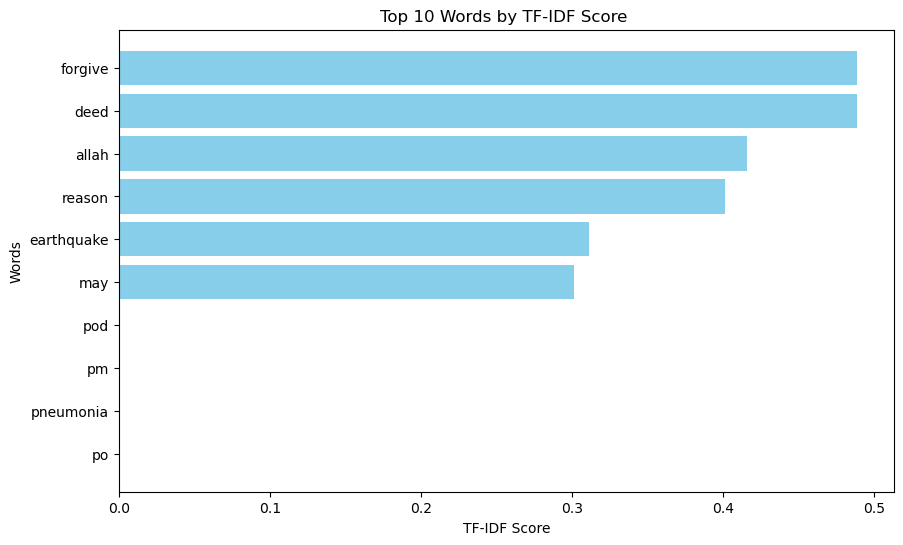

pandas.core.frame.DataFrame

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vec  = TfidfVectorizer() #A measure of how important a word is in a document or corpus

#The text data in full_data was fitted and transformed using tfidf_vec to generate the TF-IDF feature matrix full_tfidf
texts_with_target_1 = full_data[full_data['target'] == 1]['text']
text_X_tfidf  = tfidf_vec.fit_transform(texts_with_target_1)

print('feature sizs:',text_X_tfidf.shape[1]) #Shows how many features the text has been converted into




feature_names = tfidf_vec.get_feature_names_out()
print(feature_names.shape)
tfidf_scores = text_X_tfidf[0].toarray().flatten()
print(tfidf_scores.shape)
tfidf_data = pd.DataFrame({
    'word': feature_names,
    'tfidf': tfidf_scores
})


# The top N terms with the highest TF-IDF value are selected
top_n = 10
top_n_tfidf = tfidf_data.sort_values(by='tfidf', ascending=False).head(top_n)



plt.figure(figsize=(10, 6))
plt.barh(top_n_tfidf['word'], top_n_tfidf['tfidf'], color='skyblue')
plt.xlabel('TF-IDF Score')
plt.ylabel('Words')
plt.title(f'Top {top_n} Words by TF-IDF Score ')
plt.gca().invert_yaxis()
plt.show()
type(top_n_tfidf)


Due to the small amount of text, TfidfVectorizer is not as effective as CountVectorizer

### Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [7]:

from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [19]:
def text2vec(type,train_data,test_data):
    vec=None
    if type=='CountVectorizer':
        # vec = CountVectorizer(lowercase=True,stop_words='english',min_df=.0005)
        vec = CountVectorizer(lowercase=True,stop_words='english',max_features=1000)
        pass
    elif type=='TfidfVectorizer':
        vec  = TfidfVectorizer(lowercase=True,stop_words='english')
        pass
    else :
        pass
    if vec is not None:
        text_X_train = vec.fit_transform(train_data)
        text_X_test =vec.transform(test_data)
        print('text_X_train',text_X_train.shape,'text_X_test',text_X_test.shape)
        return text_X_train.todense() ,text_X_test.todense()
        
    return None

In [20]:

text_X_train,text_X_test =text2vec('CountVectorizer', 
                                   full_data[full_data['target'].notnull()]['text'],
                                   full_data[full_data['target'].isnull()]['text'])

X_train =np.concatenate([kw_X_train,text_X_train],axis=1)
X_test =np.concatenate([kw_X_test,text_X_test],axis=1)

X_train =np.asarray(X_train)
X_test =np.asarray(X_test)
y_train =np.asarray(full_data[full_data['target'].notnull()]['target']) 


X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, stratify = y_train)
print(X_train.shape)
print(X_valid.shape)
print(type(X_train))


text_X_train (7613, 1000) text_X_test (3263, 1000)
(6090, 1216)
(1523, 1216)
<class 'numpy.ndarray'>


Define the LSTM model

In [21]:

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = x[:, -1, :]  
        x = self.dropout(x)
        x = self.fc(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
         # Initialize hidden states
         h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         hidden = (h0, c0)
         return hidden
    


In [22]:
torch.manual_seed(42)
# Hyper Parameters
BATCH_SIZE = 16

train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

valid_dataset = TensorDataset(torch.from_numpy(X_valid),torch.from_numpy(y_valid))
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

Training by CountVectorizer data

In [23]:

max_norm = 5
EPOCH = 10       
LR = 0.001    # learning rate

        


# Create the model with modified layer dimensions
lstm = LSTM(
    num_layers=3,
    hidden_dim=256,
    output_dim=1,
    embedding_dim=128,
    vocab_size=100000,
).to(device)
# Loss function and optimizer with L2 regularization
lossfun = nn.BCEWithLogitsLoss()  # Binary classification
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR, weight_decay=0.001)  # L2 regularization



lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    
    h = lstm.init_hidden(BATCH_SIZE)
    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        h = tuple([each.detach()for each in h])
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        loss = lossfun(yHat, y)
    
        # print("Raw outputs (yHat):", yHat)
        optimizer.zero_grad()
        loss.backward() 
        
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm)
        optimizer.step()
        
        preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
        acc = accuracy_score(y.cpu().numpy(), preds)
        batchAcc.append(acc * 100)
        batchLoss.append(loss.item())
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    yTrue, yPred = [], []
    with torch.no_grad():
        
        h = lstm.init_hidden(BATCH_SIZE)
    
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            h = tuple([each.detach()for each in h])
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
            yPred.extend(preds)
            yTrue.extend(y.cpu().numpy())
            
            # print(preds)
            batchAcc.append(accuracy_score(y.cpu().numpy(), preds) * 100)
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))


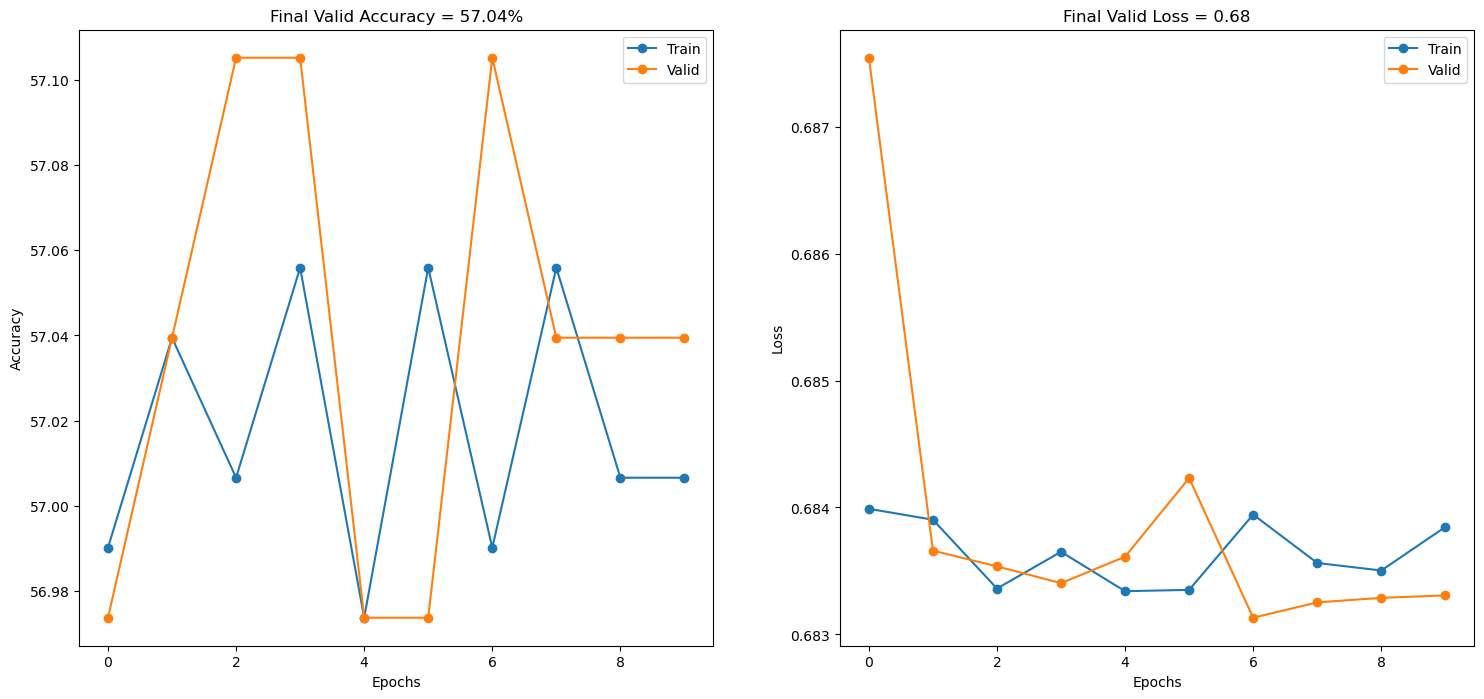

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Valid')
ax[0].set_title(f'Final Valid Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Valid')
ax[1].set_title(f'Final Valid Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

Word Embedding by Tokenizer


In [8]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_FEATURES = 5000


feature ='final_text'
full_data['final_text'] = full_data['keyword'] + ' ' + full_data['text']


word_tokenizer = Tokenizer(num_words=MAX_FEATURES)
feature_text =full_data[full_data['target'].notnull()][feature].values
print(feature_text.shape)
word_tokenizer.fit_on_texts(feature_text)

vocab_length = len(word_tokenizer.word_index) + 1
print(word_tokenizer)
print('vocab_length:',vocab_length)
token_X = word_tokenizer.texts_to_sequences(feature_text)
print('token_X',len(token_X))
# print(token_X)

max_seq_len = 20  # Sets the maximum sequence length
X_padded = pad_sequences(token_X, maxlen=max_seq_len,padding='post', truncating='post')
print(X_padded.shape)

token_df = pd.DataFrame(X_padded)


X_train =full_data[full_data['target'].notnull()]
if len(X_train) != len(token_df):
    raise ValueError("The number of rows in full_data and token_df must match.")
X_train = pd.concat([X_train, token_df], axis=1)




(7613,)
vocab_length: 13106
token_X 7613
(7613, 20)


In [26]:
token_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,268,3766,470,80,85,1328,3767,0,0,0,0,0,0,0,0,0,0,0,0,0
1,268,53,1,301,1021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,268,1456,1329,1784,471,409,90,1784,471,427,917,0,0,0,0,0,0,0,0,0
3,268,15,3768,54,90,427,49,0,0,0,0,0,0,0,0,0,0,0,0,0
4,268,47,1022,220,1604,102,54,196,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,268,71,659,1003,904,137,31,549,36,0,0,0,0,0,0,0,0,0,0,0
7609,268,596,125,1,49,159,244,397,251,0,0,0,0,0,0,0,0,0,0,0
7610,268,608,281,1319,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7611,268,20,953,2694,107,59,340,4382,2694,1611,3299,1034,4383,2202,27,0,0,0,0,0


In [27]:
X_train.head(-50)

,keyword,text,target,final_text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,UNK,deed reason earthquake may allah forgive,1.0,UNK deed reason earthquake may allah forgive,268,3766,470,80,85,1328,3767,0,0,0,0,0,0,0,0,0,0,0,0,0
1,UNK,forest fire near ronge sask canada,1.0,UNK forest fire near ronge sask canada,268,53,1,301,1021,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,UNK,resident asked shelter place notified officer evacuation shelter place order expected,1.0,UNK resident asked shelter place notified officer evacuation shelter place order expected,268,1456,1329,1784,471,409,90,1784,471,427,917,0,0,0,0,0,0,0,0,0
3,UNK,people receive wildfire evacuation order california,1.0,UNK people receive wildfire evacuation order california,268,15,3768,54,90,427,49,0,0,0,0,0,0,0,0,0,0,0,0,0
4,UNK,got sent photo ruby alaska smoke wildfire pours school,1.0,UNK got sent photo ruby alaska smoke wildfire pours school,268,47,1022,220,1604,102,54,196,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7558,wrecked,coleslaw wrecked,0.0,wrecked coleslaw wrecked,133,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7559,wrecked,exotic car wrecked train accident,1.0,wrecked exotic car wrecked train accident,133,59,133,55,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7560,wrecked,twin pitcher ego wrecked,0.0,wrecked twin pitcher ego wrecked,133,1354,3461,3505,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7561,wrecked,wgg lol got wrecked,0.0,wrecked wgg lol got wrecked,133,185,47,133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [9]:
y_train =X_train['target']
print(y_train.shape)
exclude_labels = [ 'target','keyword','text','final_text']
columns_to_keep = [col for col in X_train.columns if col not in exclude_labels]
X_train =X_train.loc[:, columns_to_keep]
print(X_train.shape)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, stratify = y_train)
print(X_train.shape)
print(X_valid.shape)



(7613,)
(7613, 20)
(6090, 20)
(1523, 20)


In [29]:
y_train.head(-10)

3375    1.0
5751    1.0
2224    0.0
297     0.0
3841    0.0
       ... 
5497    1.0
2109    0.0
3098    0.0
4602    0.0
4519    1.0
Name: target, Length: 6080, dtype: float64

In [30]:
X_train.head(-10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
3375,90,3556,366,919,891,962,548,2347,90,0,0,0,0,0,0,0,0,0,0,0
5751,138,2693,138,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2224,123,1718,403,867,621,34,0,0,0,0,0,0,0,0,0,0,0,0,0,0
297,223,2993,509,1358,740,33,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3841,73,3085,65,2635,73,2999,4994,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5497,194,257,194,564,307,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2109,18,1927,1234,3376,254,3377,1051,1714,4533,18,492,0,0,0,0,0,0,0,0,0
3098,216,4803,1223,47,216,185,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4602,27,4587,1762,701,7,560,4100,65,70,27,65,463,0,0,0,0,0,0,0,0


In [10]:
torch.manual_seed(42)
# Hyper Parameters
BATCH_SIZE = 64


train_dataset = TensorDataset(torch.tensor(X_train.values), torch.tensor(y_train.values))
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

valid_dataset = TensorDataset(torch.tensor(X_valid.values),torch.tensor(y_valid.values))
valid_dataloader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

Traning by  Tokenizer Data

In [32]:
# Hyper Parameters
max_norm = 5
EPOCH = 30
LR = 0.001 
 

# Create the model with modified layer dimensions
lstm = LSTM(
    num_layers=3,
    hidden_dim=256,
    output_dim=1,
    embedding_dim=128,
    vocab_size=vocab_length,
).to(device)

# Loss function and optimizer with L2 regularization
lossfun = nn.BCEWithLogitsLoss()  # Binary classification
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR, weight_decay=0.001)  # L2 regularization


lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    

    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        current_batch_size = X.size(0)
        h = lstm.init_hidden(current_batch_size)
  
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        loss = lossfun(yHat, y)
    
        # print("Raw outputs (yHat):", yHat)
        optimizer.zero_grad()
        loss.backward() 
        
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm)
        optimizer.step()
        
        preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
        acc = accuracy_score(y.cpu().numpy(), preds)
        batchAcc.append(acc * 100)
        batchLoss.append(loss.item())
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    yTrue, yPred = [], []
    
    
    with torch.no_grad():
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            current_batch_size = X.size(0)
            h = lstm.init_hidden(current_batch_size)
       
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
            yPred.extend(preds)
            yTrue.extend(y.cpu().numpy())
            
            # print(preds)
            batchAcc.append(accuracy_score(y.cpu().numpy(), preds) * 100)
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))
        


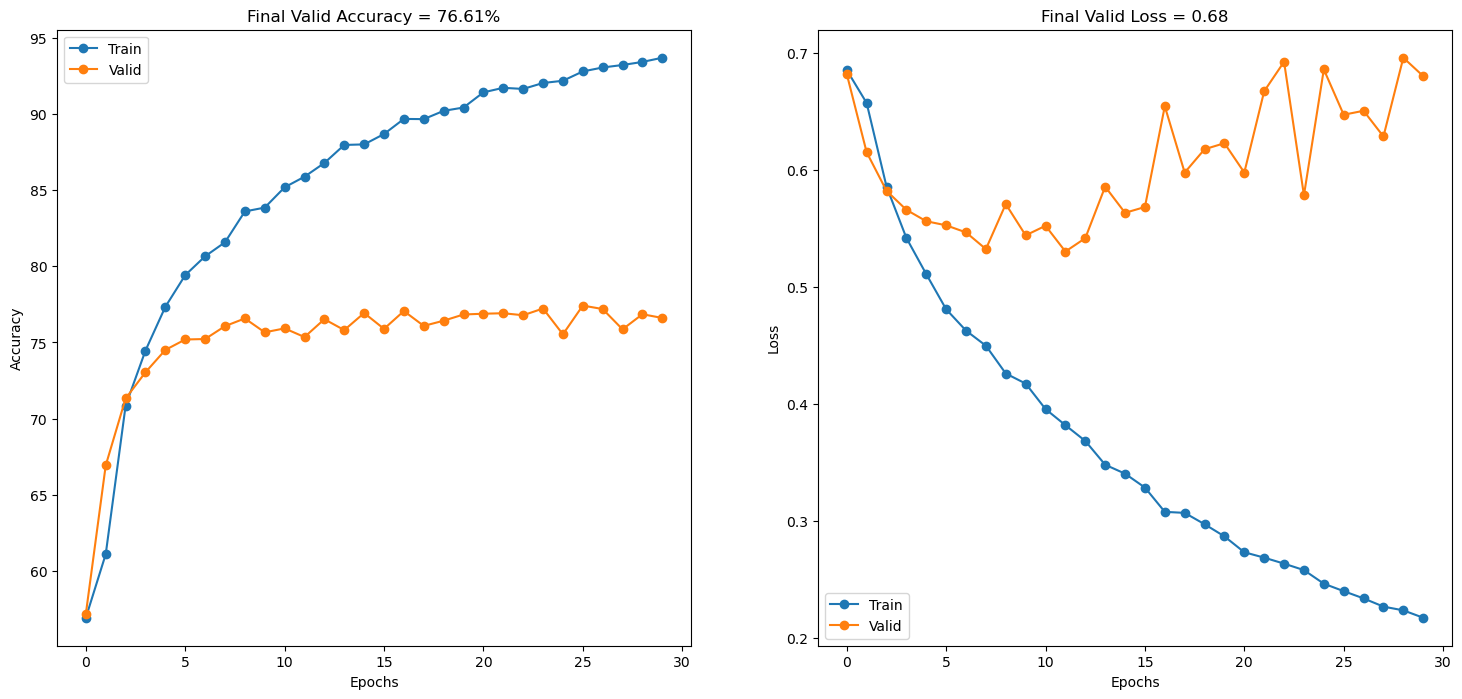

: 

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Valid')
ax[0].set_title(f'Final Valid Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Valid')
ax[1].set_title(f'Final Valid Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

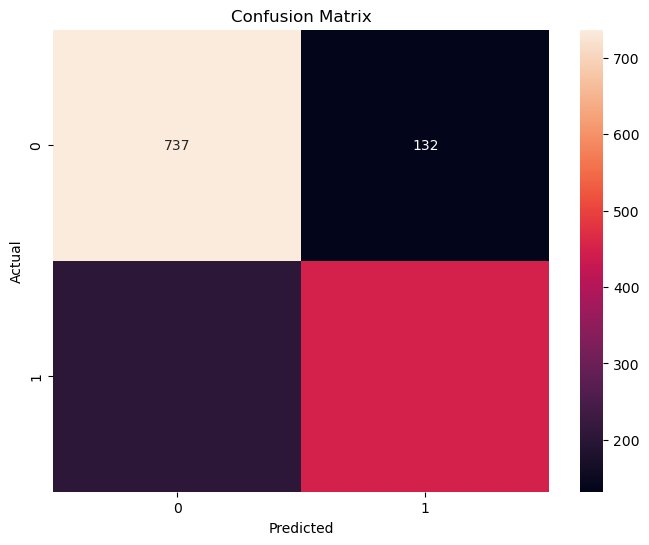

In [33]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

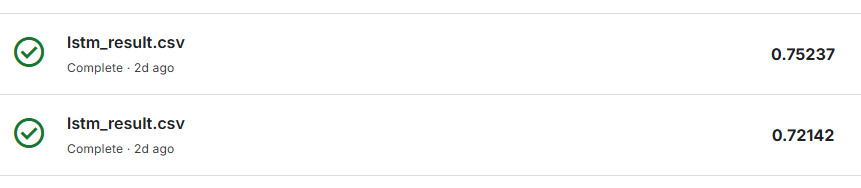

Word Embedding by Word2Vec



In [ ]:
! pip install  gensim

In [30]:
from gensim.models import Word2Vec
EMBEDDING_DIM = 256
feature_text =full_data[full_data['target'].notnull()][feature].values
feature_text = [text.split() for text in feature_text] #[[a,b,c],[d,e,f]]
print(len(feature_text),feature_text[0])
w2v_model = Word2Vec(sentences=feature_text, vector_size=EMBEDDING_DIM, window=5, min_count=0,sg=1)
w2v_model.train(feature_text, total_examples=len(feature_text), epochs=10)

7613 ['UNK', 'deed', 'reason', 'earthquake', 'may', 'allah', 'forgive']


(716548, 726560)

In [31]:

print("Vocabulary count:",len(w2v_model.wv.key_to_index))
# for word in w2v_model.wv.key_to_index:
#     print(word)

if "unk" not in w2v_model.wv:
    # Add a randomly initialized vector to <UNK>
    w2v_model.wv.add_vector("unk", np.random.uniform(-0.25, 0.25, EMBEDDING_DIM))
    
if 'unk' in w2v_model.wv:
    print("Word 'unk' is in the vocabulary.")
else:
    print("Word 'unk' is NOT in the vocabulary.")

Vocabulary count: 13105
Word 'unk' is in the vocabulary.


c:\Users\SEELE\.conda\envs\python_env\lib\site-packages\gensim\models\keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


In [13]:
w2v_model.wv.most_similar('dead', topn=10)

[('exchanging', 0.7616621851921082),
 ('emmerdale', 0.7535473108291626),
 ('aim', 0.7430902719497681),
 ('kaduna', 0.7351449728012085),
 ('shot', 0.7258478403091431),
 ('ross', 0.7247518301010132),
 ('ushed', 0.7209054231643677),
 ('dozen', 0.7141162753105164),
 ('val', 0.7137678861618042),
 ('askcharley', 0.7106947898864746)]

In [14]:
def get_weight_matrix_w2v(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

def get_weight_matrix_glove(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.word_vectors[model.dictionary[word]]
    return weight_matrix

word_index = word_tokenizer.word_index
embedding_vectors_w2v = get_weight_matrix_w2v(w2v_model, word_index)

In [15]:


class LSTM_w2v(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout=0.8,pretrained_weights=None):
        super(LSTM_w2v, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_weights is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weights))
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        x = self.embedding(x)
        x, hidden = self.lstm(x, hidden)
        x = x[:, -1, :]  
        x = self.dropout(x)
        x = self.fc(x)
        return x, hidden
    
    def init_hidden(self, batch_size):
         # Initialize hidden states
         h0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         c0 = torch.zeros((self.num_layers, batch_size, self.hidden_dim)).to(device)
         hidden = (h0, c0)
         return hidden
    
    



In [26]:
# Hyper Parameters
max_norm = 5
EPOCH = 20
LR = 0.001 
 

# Create the model with modified layer dimensions
lstm = LSTM_w2v(
    num_layers=3,
    hidden_dim=256,
    output_dim=1,
    embedding_dim=EMBEDDING_DIM,
    vocab_size=len(w2v_model.wv.key_to_index),
    pretrained_weights=embedding_vectors_w2v
).to(device)

# Loss function and optimizer with L2 regularization
lossfun = nn.BCEWithLogitsLoss()  # Binary classification
optimizer = torch.optim.Adam(lstm.parameters(), lr=LR, weight_decay=0.001)  # L2 regularization


lstm.to(device)
trainAcc = []
trainLoss = []
devAcc = []
devLoss = []

yTrue, yPred = [], []

for epochi in range(EPOCH):
    batchAcc = []
    batchLoss = []
    
    lstm.train()
    
    for X, y in train_dataloader:
        X, y = X.to(device, dtype=torch.int), y.to(device)
        current_batch_size = X.size(0)
        h = lstm.init_hidden(current_batch_size)
  
        yHat, h = lstm.forward(X,h)
        yHat = yHat.squeeze()
        loss = lossfun(yHat, y)
    
        # print("Raw outputs (yHat):", yHat)
        optimizer.zero_grad()
        loss.backward() 
        
        nn.utils.clip_grad_norm_(lstm.parameters(), max_norm)
        optimizer.step()
        
        preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
        acc = accuracy_score(y.cpu().numpy(), preds)
        batchAcc.append(acc * 100)
        batchLoss.append(loss.item())
    
    trainAcc.append(np.mean(batchAcc))
    trainLoss.append(np.mean(batchLoss))
    
    lstm.eval()
    yTrue, yPred = [], []
    
    
    with torch.no_grad():
        batchAcc = []
        batchLoss = []
        for X, y in valid_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            current_batch_size = X.size(0)
            h = lstm.init_hidden(current_batch_size)
       
            yHat, h = lstm.forward(X,h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
            yPred.extend(preds)
            yTrue.extend(y.cpu().numpy())
            
            # print(preds)
            batchAcc.append(accuracy_score(y.cpu().numpy(), preds) * 100)
            batchLoss.append(loss.item())
        devAcc.append(np.mean(batchAcc))
        devLoss.append(np.mean(batchLoss))
        


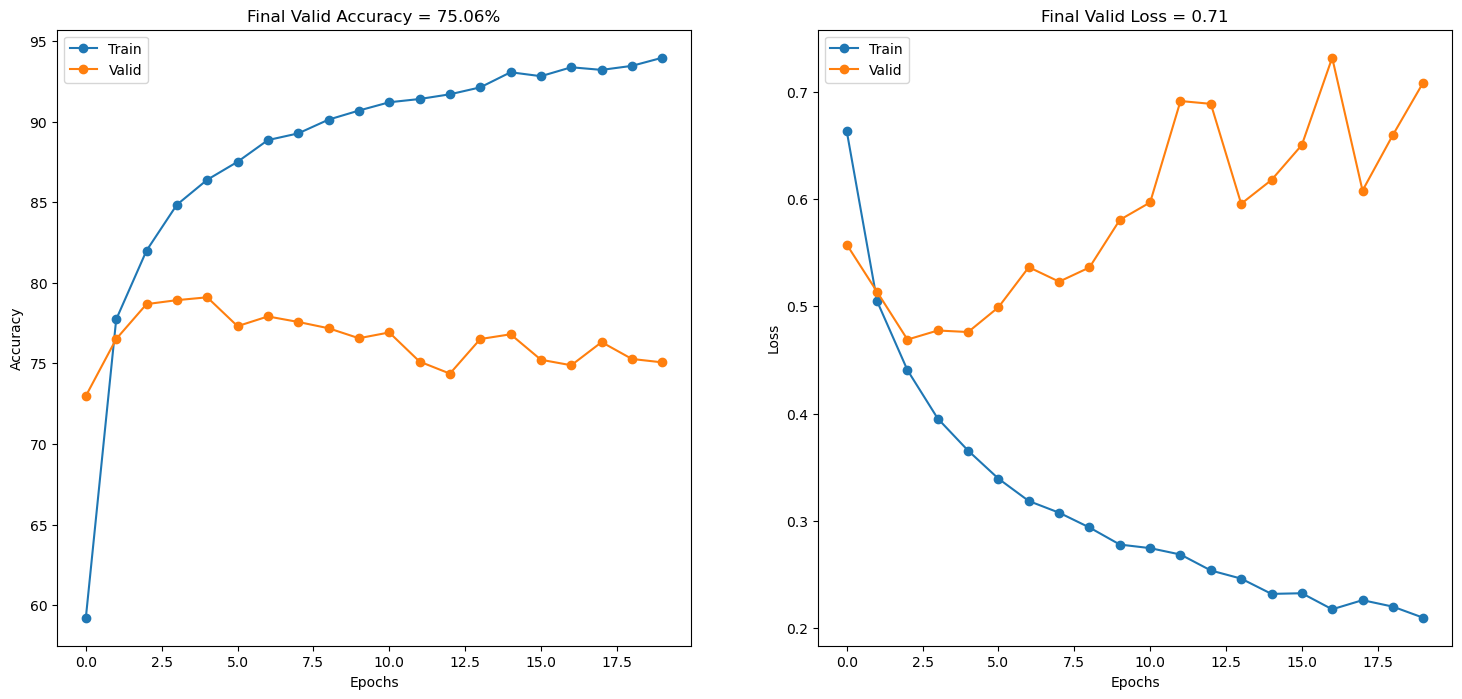

In [27]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(devAcc, 'o-', label = 'Valid')
ax[0].set_title(f'Final Valid Accuracy = {devAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(devLoss, 'o-', label = 'Valid')
ax[1].set_title(f'Final Valid Loss = {devLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.show()

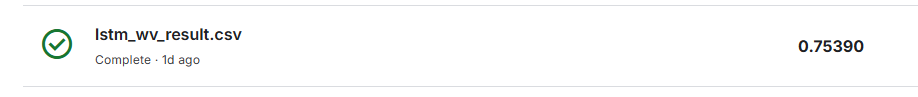

In [35]:
# # Save the state at some point during training
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': epoch,
#     'loss': loss,
# }, 'checkpoint.tar')
 
# # After that, you can restore the model and optimizer
# checkpoint = torch.load('checkpoint.tar')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
 

### Results and Analysis (35 pts)

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [39]:

test_token_X = word_tokenizer.texts_to_sequences(full_data[full_data['target'].isnull()][feature].values)
test_token_X = pad_sequences(test_token_X, maxlen=max_seq_len, padding='post', truncating='post')
test_token_df = pd.DataFrame(test_token_X)

X_test = full_data[full_data['target'].isnull()]
X_test = X_test.reset_index(drop=True) 
print(X_test.shape,test_token_df.shape)
if len(X_test) != len(test_token_df):
    raise ValueError("The number of rows in X_test and test_token_df must match.")
X_test = pd.concat([X_test, test_token_df], axis=1)

X_test =X_test.loc[:, columns_to_keep]
print(X_test.shape)

(3263, 4) (3263, 20)
(3263, 20)


In [ ]:
test_token_df

In [40]:
y_test =np.empty((X_test.shape[0], 1))
print(y_test.shape)
test_dataset = TensorDataset(torch.tensor(X_test.values), torch.tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE)

(3263, 1)


In [41]:


yPreds = []

lstm.eval()

with torch.no_grad():
    for X, y in test_dataloader:
        current_batch_size = X.size(0)
        h = lstm.init_hidden(current_batch_size)
        X, _ = X.to(device, dtype=torch.int), y.to(device)
        yHat, h = lstm.forward(X, h)
        yHat = yHat.squeeze()
        preds = (torch.sigmoid(yHat) > .5).cpu().numpy()
        yPreds.extend(preds)

yPreds = np.array(yPreds, dtype=bool)
print(yPreds)

[ True False  True ...  True  True  True]


In [42]:
def save_data(y_pred,filename):
    submission=pd.DataFrame ( {
    "id" : test_data [ "id" ],
    "target" : y_pred.astype (int)
    })
    submission.to_csv ( filename+'_result.csv',index=False)

In [43]:
yPreds
save_data(yPreds,'lstm_wv')

### Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

First, we imported the data and gained a thorough understanding of what the training data looks like before cleaning it. We also visualized most of the data, cleaned the location field which had missing data, and through graphical analysis, we discovered the effectiveness of the keyword field. Then, as part of our exploratory data analysis (EDA), we preprocessed the training data by calculating punctuation, the appearance of numbers, and modifying the Text field to make it easier for computers to understand.

After preparing the training data, we split it into two subsets—training and validation—to better train our model.

Upon testing, we found that using Bag-of-Words (BOW) and Term Frequency-Inverse Document Frequency (TF-IDF) for processing text data led to an excessive number of dimensions, which heavily consumed resources during training and was not conducive for deep learning models. Additionally, the training accuracy (ACC) values were relatively low. Therefore, we reduced the dimensionality by directly applying tokenizer and word2vec methods on strings and retrained with LSTM. Under the same environment, the training time was reduced from 60 minutes to 2 minutes, and the test ACC reached 0.75. However, the training accuracy was significantly higher than the validation accuracy, indicating an overfitting issue. The model performed well on the training data but poorly on the validation data. The volatility in validation accuracy and loss was greater compared to the training metrics, suggesting that the model's performance on unseen data is unstable and inconsistent, showing poor generalization capability on validation or test data.

We speculate that due to hyperparameter reasons, the training results of the model are unstable, with abnormal fluctuations at certain moments.